In [666]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import chi2
from scipy.linalg import sqrtm
from numpy.linalg import det
import numpy.linalg as LA
import matplotlib.pyplot as plt
import math

def generate_covariance(true_mu, dims):
    S = np.tril(np.random.randn(dims, dims))
    cov = np.dot(S, S.T)
    while(np.linalg.det(cov) < 0.5):
        cov = cov * 2
    mu = np.random.multivariate_normal(true_mu, cov, 1)[0]

    return mu, cov

def get(dims):
    true_mu = np.zeros((dims, ))

    x_ac, C_ac = generate_covariance(true_mu, dims)
    x_c, C_c = generate_covariance(true_mu, dims)
    x_bc, C_bc = generate_covariance(true_mu, dims)
    
    C_bc = np.copy(C_ac)
    
    C_a = LA.inv(LA.inv(C_ac) + LA.inv(C_c))
    C_b = LA.inv(LA.inv(C_bc) + LA.inv(C_c))

    x_a = C_a @ (LA.inv(C_ac) @ x_ac + LA.inv(C_c) @ x_c)
    x_b = C_b @ (LA.inv(C_bc) @ x_bc + LA.inv(C_c) @ x_c)

    C_fus = LA.inv(LA.inv(C_a) + LA.inv(C_b) - LA.inv(C_c))

    return x_a.reshape(1, dims), x_b.reshape(1, dims), C_a, C_b, C_fus


In [667]:
def plot_ellipse(covariance, ax, label_t="", linestyle='', alpha_val=0.25, color_def='red', center = [0, 0]):
    if covariance.shape[0] == 2:
        x_el = np.array([np.sin(np.linspace(0, 2*math.pi, num=63)), np.cos(np.linspace(0, 2*math.pi, num=63))])
        C = np.linalg.cholesky(covariance)
        y_el = np.dot(C, x_el)
        if len(linestyle) > 0:
            if len(label_t) > 0:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], label=label_t, alpha=alpha_val, color=color_def, linestyle=linestyle)
            else:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], alpha=alpha_val, color=color_def, linestyle=linestyle)            
        else:
            if len(label_t) > 0:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], label=label_t, alpha=alpha_val, color=color_def)
            else:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], alpha=alpha_val, color=color_def)            

def mutual_covariance(cov_a, cov_b):
    D_a, S_a = np.linalg.eigh(cov_a)
    D_a_sqrt = sqrtm(np.diag(D_a))
    D_a_sqrt_inv = inv(D_a_sqrt)
    M = np.dot(np.dot(np.dot(np.dot(D_a_sqrt_inv, inv(S_a)), cov_b), S_a), D_a_sqrt_inv)    # eqn. 10 in Sijs et al.
    D_b, S_b = np.linalg.eigh(M)
    D_gamma = np.diag(np.clip(D_b, a_min=1.0, a_max=None))   # eqn. 11b in Sijs et al.
    return np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(S_a, D_a_sqrt), S_b), D_gamma), inv(S_b)), D_a_sqrt), inv(S_a))  # eqn. 11a in Sijs et al

In [668]:
x_a, x_b, C_a, C_b, C_fus = get(2)

x_a = x_a.reshape(1, 2)
x_b = x_b.reshape(1, 2)

def get_critical_value(dimensions, alpha):
    return chi2.ppf((1 - alpha), df=dimensions)

eta = get_critical_value(2, 0.05)
print(eta)

def inv(mat):
    return np.linalg.inv(mat)

5.991464547107979


In [669]:
def objective(S):
    return -(S[0]*S[3])

def constraint1(S):
    S = S.reshape(2, 2).T
    A = inv(C_a) - S@S.T
    return np.linalg.eig(A)[0][0]
def constraint2(S):
    S = S.reshape(2, 2).T
    A = inv(C_a) - S@S.T
    return np.linalg.eig(A)[0][1]
def constraint3(S):
    S = S.reshape(2, 2).T
    A = inv(C_b) - S@S.T
    return np.linalg.eig(A)[0][0]
def constraint4(S):
    S = S.reshape(2, 2).T
    A = inv(C_b) - S@S.T
    return np.linalg.eig(A)[0][1]
    
def psuedoinv(A):
    A[np.where(A<=1e-5)] = 1e-5
    
def relu(v):
    return np.log1p(1 + np.exp(v))
        
def pinv(A):
    RELU = np.vectorize(relu)
    tmp_eig, tmp_egv = LA.eig(A)
    M_inv = tmp_egv @ np.diag(1/RELU(tmp_eig)) @ tmp_egv.T
    M = tmp_egv @ np.diag(RELU(tmp_eig)) @ tmp_egv.T
    return M, M_inv

def prob_constraint(S):
    S = S.reshape(2, 2).T
    C_c_inv = S@S.T

#     tmp = inv(C_a) - C_c_inv
#     tmp_eig, tmp_egv = LA.eig(tmp)
#     C_ac = tmp_egv @ np.diag(1/RELU(tmp_eig)) @ tmp_egv.T
#     C_ac_inv = tmp_egv @ np.diag(RELU(tmp_eig)) @ tmp_egv.T

    C_ac_inv, C_ac = pinv(inv(C_a) - C_c_inv)
    C_bc_inv, C_bc = pinv(inv(C_b) - C_c_inv)
    
    _, C_abc_inv_inv = pinv(C_ac_inv + C_bc_inv)
    _, C_abc_inv = pinv(C_ac + C_bc)
    
#     tmp = inv(C_b) - C_c_inv
#     tmp_eig, tmp_egv = LA.eig(tmp)
#     C_bc = tmp_egv @ np.diag(1/RELU(tmp_eig)) @ tmp_egv.T
#     C_bc_inv = tmp_egv @ np.diag(RELU(tmp_eig)) @ tmp_egv.T
        
#     C_ac = inv(inv(C_a) - C_c_inv)
#     C_bc = inv(inv(C_b) - C_c_inv)
    x_c = (C_abc_inv_inv @ (C_ac_inv @ x_a.T + C_bc_inv @ x_b.T)).T
    x_ac = (C_ac @ (inv(C_a) @ x_a.T - C_c_inv @ x_c.T)).T
    x_bc =(C_bc @ (inv(C_b) @ x_b.T - C_c_inv @ x_c.T)).T
    f = ((x_ac - x_bc) @ C_abc_inv @ (x_ac - x_bc).T)[0][0]
#     print(f)
    return eta - f

def constraint5(S):
    return S[2]



In [670]:
con1 = {'type': 'ineq', 'fun': constraint1}
con2 = {'type': 'ineq', 'fun': constraint2}
con3 = {'type': 'ineq', 'fun': constraint3}
con4 = {'type': 'ineq', 'fun': constraint4}
con5 = {'type': 'ineq', 'fun': prob_constraint}
con6 = {'type': 'eq', 'fun': constraint5}
cons = [con1, con2, con3, con4, con5, con6]


In [671]:
S_0 = 0.2*(np.linalg.cholesky(inv(mutual_covariance(C_a, C_b))).T).reshape(4, )
prob_constraint(S_0)

3.343337546649882

In [672]:
print('Before optimization, we have...')
print ('objective is',objective(S_0))
print ('constraint1 is ',constraint1(S_0))
print ('constraint2 is ',constraint2(S_0))
print ('constraint3 is ',constraint3(S_0))
print ('constraint4 is ',constraint4(S_0))
print ('constraint5 is ',constraint5(S_0))
print ('prob_constraint is ',prob_constraint(S_0))


Before optimization, we have...
objective is -0.46685179815372885
constraint1 is  8.799515529531341
constraint2 is  14.266642976850711
constraint3 is  8.799515529531341
constraint4 is  14.266642976850711
constraint5 is  0.0
prob_constraint is  3.343337546649882


In [673]:
sol = minimize(objective, S_0, method='trust-constr', constraints=cons)

/usr/local/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


In [674]:
print(sol)

 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 172
      cg_stop_cond: 4
            constr: [array([2.12939467e-07]), array([7.84864849]), array([2.12939467e-07]), array([7.84864849]), array([2.01627862e-07]), array([-3.03547702e-32])]
       constr_nfev: [800, 800, 800, 800, 800, 800]
       constr_nhev: [0, 0, 0, 0, 0, 0]
       constr_njev: [0, 0, 0, 0, 0, 0]
    constr_penalty: 1.0
  constr_violation: 3.03547702395435e-32
    execution_time: 2.0528290271759033
               fun: -7.27499878584405
              grad: array([-2.27828638, -0.        , -0.        , -3.1931889 ])
               jac: [array([[-6.48586341,  0.50719446,  0.3541581 , -0.02769515]]), array([[ 0.09948552,  1.27219379, -0.35415816, -4.52887766]]), array([[-6.48586341,  0.50719446,  0.3541581 , -0.02769515]]), array([[ 0.09948552,  1.27219379, -0.35415816, -4.52887766]]), array([[ 0.28678391, -0.37677598, -2.03260845, -6.33037639]]), array([[ 0., -0.,  

In [675]:
S = sol.x.reshape(2,2)

objective is -7.27499878584405
constraint1 is  2.1293946694811439e-07
constraint2 is  7.848648491804071
constraint3 is  2.1293946694811439e-07
constraint4 is  7.848648491804071
constraint5 is  -3.03547702395435e-32
prob_constraint is  2.016278619620948e-07


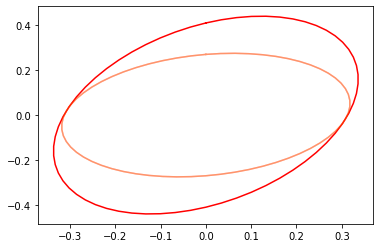

[[ 3.19318890e+00 -3.03547702e-32]
 [-8.89694081e-01  2.27828638e+00]]


<Figure size 432x288 with 0 Axes>

In [676]:
S = sol.x
S = S.reshape(2, 2).T

C_c = inv(S.T) @ inv(S)

print ('objective is',objective(sol.x))
print ('constraint1 is ',constraint1(sol.x))
print ('constraint2 is ',constraint2(sol.x))
print ('constraint3 is ',constraint3(sol.x))
print ('constraint4 is ',constraint4(sol.x))
print ('constraint5 is ',constraint5(sol.x))
print ('prob_constraint is ',prob_constraint(sol.x))

ax = plt.axes()
plot_ellipse(C_c, ax, alpha_val=1)
plot_ellipse(C_a, ax)
plot_ellipse(C_b, ax)
plot_ellipse(mutual_covariance(C_a, C_b), ax, color_def='orange')
plt.show()
plt.cla()
plt.clf()

print(S)

OURS:0.004555546160947341
EI:0.00734111302943613
TRUE:0.003660132413016321


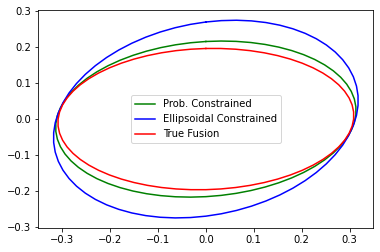

In [680]:
ax = plt.axes()
fus_PC = inv(inv(C_a) + inv(C_b) - inv(C_c))
fus_EI = inv(inv(C_a) + inv(C_b) - inv(mutual_covariance(C_a, C_b)))
# plot_ellipse(C_a, ax)
# plot_ellipse(C_b, ax)
plot_ellipse(fus_PC, ax, color_def="green", alpha_val=1, label_t="Prob. Constrained")
plot_ellipse(fus_EI, ax, color_def="blue", alpha_val=1, label_t="Ellipsoidal Constrained")
plot_ellipse(C_fus, ax, alpha_val=1, label_t="True Fusion")
print("OURS:" + str(LA.det(fus_PC)))
print("EI:" + str(LA.det(fus_EI)))
print("TRUE:" + str(LA.det(C_fus)))
plt.legend()
plt.show()